In [34]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import random
import time
from tqdm.notebook import tqdm

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import KarateClub
import networkx as nx
from scipy import sparse as sp

from models import NodeClassificationGraphTransformer
from preprocess import AddLaplacianPosEncoding, SBMDataset
from train import train_one_epoch, evaluate

In [35]:
SEED = 0

if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print('cuda not available')
    device = torch.device("cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)


cuda available with GPU: NVIDIA GeForce GTX 1660 Ti


In [54]:
# Dimension of positional encoding, ex number of non-trivial eigenvalues for laplacian positional encoding
POS_ENCODING_DIM = 10

# Training parameters
BATCH_SIZE = 128
INIT_LR = 0.0007
WEIGHT_DECAY = 0.0
LR_REDUCE_FACTOR = 0.5
PATIENCE = 15
MIN_LR = 1e-6
EPOCHS = 100

# Network parameters
n_hidden = 64
n_head = 8
n_feedforward = 160
n_layers = 2
input_dropout = 0.0
dropout = 0.0
norm = 'layer'
readout = 'mean'
pos_encoding = None

In [64]:
# Dataset and prior transforms
data_transforms = T.Compose([
    SBMDataset(),
    AddLaplacianPosEncoding(POS_ENCODING_DIM),
    #T.AddSelfLoops('edge_attr')
    ])


dataset_train = KarateClub(transform=data_transforms)
dataloader_train = torch_geometric.loader.DataLoader(dataset_train, batch_size=1)

In [65]:
karate_graph = dataset_train[0]

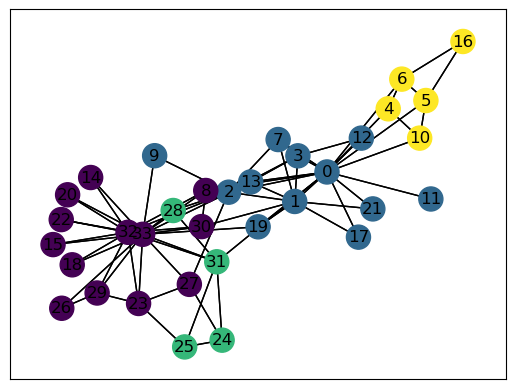

In [66]:
karate_nx = torch_geometric.utils.convert.to_networkx(karate_graph)
nx.draw_networkx(karate_nx, arrows=False, node_color=karate_graph.y)

In [67]:
n_nodes_input = torch.unique(karate_graph.x).size(0)
n_classes = torch.unique(dataset_train.y).size(0)

checkpoint_path = 'checkpoints/Karate.pth'

model = NodeClassificationGraphTransformer(n_nodes_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers,
                                             n_classes,
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM,
                                             pos_encoding=pos_encoding,
                                             norm=norm)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=LR_REDUCE_FACTOR,
                                                 patience=PATIENCE,
                                                 verbose=True)

epoch_train_losses = []
epoch_train_accs = []

In [68]:
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    g = next(iter(dataloader_train))
    g = g.to(device)

    h = g.x.to(torch.long)

    if pos_encoding == 'laplacian':
        precomputed_eigenvectors = g.laplacian_eigs
        sign_flip = torch.rand(precomputed_eigenvectors.size(1)).to(device)
        sign_flip[sign_flip>=0.5] = 1.0; sign_flip[sign_flip<0.5] = -1.0
        precomputed_eigenvectors = precomputed_eigenvectors * sign_flip.unsqueeze(0)
    elif pos_encoding == 'wl':
        precomputed_eigenvectors = g.wl_encoding
    elif pos_encoding == 'both':
        precomputed_eigenvectors = (g.laplacian_eigs, g.wl_encoding)
    else:
        precomputed_eigenvectors = None

    y = g.y

    optimizer.zero_grad()
    out, _ = model(g, h, precomputed_eigenvectors=precomputed_eigenvectors)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.detach().item()

    pred = out.argmax(dim=-1)
    acc = (pred==y).sum()/len(y)
    epoch_acc += acc.detach().item()

    epoch_train_losses.append(epoch_loss)
    epoch_train_accs.append(epoch_acc)

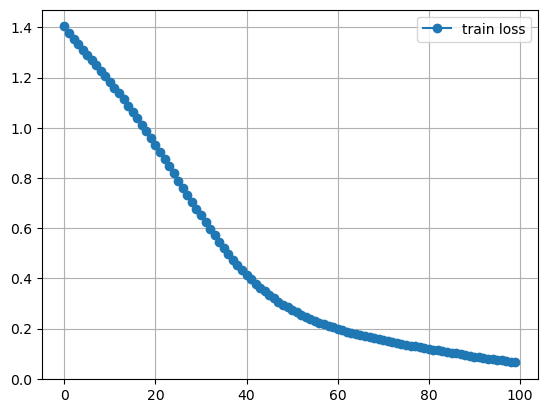

In [69]:
plt.plot(range(EPOCHS), epoch_train_losses, '-o', label='train loss')
plt.legend()
plt.grid()

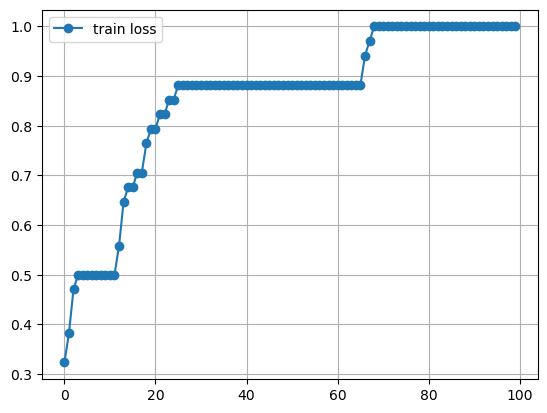

In [70]:
plt.plot(range(EPOCHS), epoch_train_accs, '-o', label='train loss')
plt.legend()
plt.grid()

In [71]:
g = next(iter(dataloader_train))
g = g.to(device)

h = g.x.to(torch.long)

precomputed_eigenvectors = g.laplacian_eigs
sign_flip = torch.rand(precomputed_eigenvectors.size(1)).to(device)
sign_flip[sign_flip>=0.5] = 1.0; sign_flip[sign_flip<0.5] = -1.0
precomputed_eigenvectors = precomputed_eigenvectors * sign_flip.unsqueeze(0)

out, _ = model(g, h, precomputed_eigenvectors=precomputed_eigenvectors)
pred = out.argmax(dim=-1)
pred

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0], device='cuda:0')

In [72]:
g.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0], device='cuda:0')